In [1]:
import fnmatch
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
import torch
import torchsummary
import torchvision
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

sns.set_style("ticks")

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:40"

In [3]:
# set device and env vars

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

def seed_everything(seed: int=5424):
    """set random seed."""
    print(f"setting seed: {seed}")
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    if torch.device != "cpu":
        torch.cuda.manual_seed_all(seed)

def set_env_vars():
    """set env vars for cpu."""
    num_pcores = psutil.cpu_count(logical=False)
    print(f"num cores: {num_pcores}")
    os.environ["OMP_NUM_THREADS"] = str(num_pcores)
    os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
    os.environ["KMP_BLOCKTIME"] = "1"
    torch.set_num_interop_threads(1)
    torch.set_num_threads(num_pcores)

        
seed_everything()
set_env_vars()

using device: cuda
setting seed: 5424
num cores: 10


In [4]:
imgnet_stats = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]
img_transforms = {
    "train": torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*imgnet_stats)
    ]),
    "valid": torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*imgnet_stats)
        ]),
    "test": torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*imgnet_stats)

    ])
}

In [5]:
# transform dataset
TRAIN_DIR = "./data/train/"
TEST_DIR = "./data/test/"

dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["train"])
valid_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["valid"])
test_dataset = torchvision.datasets.ImageFolder(TEST_DIR, transform=img_transforms["test"])
dataset.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

In [6]:
def data_distribution(dataset=dataset, path:str="./data/train/"):
    """show data distribtion of each class."""
    cls_count = dict.fromkeys(dataset.class_to_idx, 0)
    for cls in cls_count.keys():
        cls_count[cls] = len(fnmatch.filter(os.listdir(f"{path}/{cls}"), "*.png"))
    return cls_count
print(data_distribution(dataset))

{'paper': 840, 'rock': 840, 'scissors': 840}


In [7]:
# create train & valid dataset
dataset_len = len(dataset.targets)
dataset_idx = [x for x in range(dataset_len)]
train_idx, valid_idx = train_test_split(dataset_idx, test_size=0.3, stratify=dataset.targets, shuffle=True)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
valid_dataset = torch.utils.data.Subset(valid_dataset, valid_idx)
print(f" train, valid, test sizes: {len(train_dataset), len(valid_dataset), len(test_dataset)}")


 train, valid, test sizes: (1764, 756, 372)


In [8]:
# create dataloaders from datasets

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, pin_memory=True)

In [9]:
def get_class_dists(dataloader: DataLoader):
    classes = {0:0, 1:0, 2:0}
    for _, labels in dataloader:
        for label in labels:
            classes[label.item()] +=1
    return classes

        
#print(f"training data classes: {get_class_dists(train_dataloader)}")
#print(f"valid data classes: {get_class_dists(valid_dataloader)}")
#print(f"test data classes: {get_class_dists(test_dataloader)}")

In [10]:
torch.cuda.empty_cache()

In [11]:
def show_data(dataloader, num_data=4):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(train_dataloader))  # batch of with images, batch of labels
    imgs, labels = batch[0][:num_data], batch[1][:num_data].tolist() # get num_data of images, labels
    fig, axes = plt.subplots(1, num_data, figsize=(8, 4))
    fig.suptitle("data with labels")
    for n in range(num_data):
        axes[n].set_title(labels[n])
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))


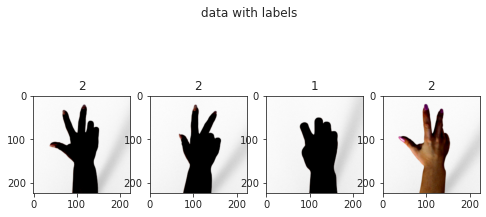

In [12]:
show_data(train_dataloader)

In [13]:
# simple network

class CNNClassifier(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cn1 = self.conv_block(3, 256, 5)
        self.cn2 = self. conv_block(256, 128)
        self.cn3 = self.conv_block(128, 64)
        self.cn4 = self.conv_block(64, 32)
        self.fc1 = torch.nn.Linear(4608, 128)
        self.fc2 = torch.nn.Linear(128, 3)

    def forward(self, x):
        x = self.cn1(x)
        x = self.cn2(x)
        x = self.cn3(x)
        x = self.cn4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return self.fc2(x)

    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1):
        return torch.nn.Sequential(
             torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size, stride=stride),
             torch.nn.BatchNorm2d(num_features=out_channels),
             torch.nn.MaxPool2d(2, 2),
             torch.nn.ReLU(),
             torch.nn.Dropout2d(p=0.4)
        )

model = CNNClassifier()
model = model.to(device)

In [14]:
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 220, 220]          19,456
       BatchNorm2d-2        [-1, 256, 220, 220]             512
         MaxPool2d-3        [-1, 256, 110, 110]               0
              ReLU-4        [-1, 256, 110, 110]               0
         Dropout2d-5        [-1, 256, 110, 110]               0
            Conv2d-6        [-1, 128, 108, 108]         295,040
       BatchNorm2d-7        [-1, 128, 108, 108]             256
         MaxPool2d-8          [-1, 128, 54, 54]               0
              ReLU-9          [-1, 128, 54, 54]               0
        Dropout2d-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 64, 52, 52]          73,792
      BatchNorm2d-12           [-1, 64, 52, 52]             128
        MaxPool2d-13           [-1, 64, 26, 26]               0
             ReLU-14           [-1, 64,

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
@torch.no_grad()
def accuracy(yhat, label):
    """accuracy of a batch"""
    yhat = torch.log_softmax(yhat, dim=1)  # softmax of logit output
    yhat = yhat.max(1)[1]  # get index of max values 
    acc = yhat.eq(label).sum() / len(yhat)
    return torch.round(acc * 100)


acc_metrics = {
    "train": [],
    "val": []
}
loss_metrics = {
    "train": [],
    "val": []
}


In [17]:
MAX_EPOCH=25

from tqdm import tqdm 

for epoch in range(MAX_EPOCH):
    torch.cuda.empty_cache()
    model.train()
    t_epoch_loss, t_epoch_acc = 0.0, 0.0
    for inputs, labels in tqdm(train_dataloader, desc="tr loop"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # call model
        acc = accuracy(outputs, labels)
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backward pass
        optimizer.step() # step optimizer
        t_epoch_loss += loss.item()  # loss per batch
        t_epoch_acc += acc.item()  # accuracy per batch
    with torch.no_grad():
        model.eval()
        v_epoch_loss, v_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(valid_dataloader, desc="ev loop"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            v_epoch_loss += loss.item()
            v_epoch_acc += acc.item()
    loss_metrics["train"].append(t_epoch_loss / len(train_dataloader))
    loss_metrics["val"].append(v_epoch_loss / len(valid_dataloader))
    acc_metrics["train"].append(t_epoch_acc / len(train_dataloader))
    acc_metrics["val"].append(v_epoch_acc / len(valid_dataloader)) 
    print(f"Epoch: [{epoch + 1}]")
    print(f"loss:\n training set: {loss_metrics['train'][-1]} validation set: {loss_metrics['val'][-1]} ")
    print(f"accuracy:\n training set: {acc_metrics['train'][-1]} validation set: {acc_metrics['val'][-1]} ")


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.00it/s]


Epoch: [1]
loss:
 training set: 0.9311171667063022 validation set: 0.08369877430959605 
accuracy:
 training set: 77.33333333333333 validation set: 98.5 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.12it/s]


Epoch: [2]
loss:
 training set: 0.11128152796614764 validation set: 0.024675644856567185 
accuracy:
 training set: 97.009009009009 validation set: 99.5 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.16it/s]


Epoch: [3]
loss:
 training set: 0.057685173272369175 validation set: 0.0044929832717267955 
accuracy:
 training set: 98.43243243243244 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.00it/s]


Epoch: [4]
loss:
 training set: 0.016925717409944523 validation set: 0.0006046395834952515 
accuracy:
 training set: 99.62162162162163 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.18it/s]


Epoch: [5]
loss:
 training set: 0.007069704485197157 validation set: 0.00015196587357972172 
accuracy:
 training set: 99.89189189189189 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.21it/s]


Epoch: [6]
loss:
 training set: 0.006477259138403308 validation set: 0.0003136170322477483 
accuracy:
 training set: 99.89189189189189 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.08it/s]


Epoch: [7]
loss:
 training set: 0.00807624064738185 validation set: 0.0014518479213639541 
accuracy:
 training set: 99.67567567567568 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.09it/s]


Epoch: [8]
loss:
 training set: 0.08858089191950581 validation set: 0.067772912893588 
accuracy:
 training set: 97.48648648648648 validation set: 97.85416666666667 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.09it/s]


Epoch: [9]
loss:
 training set: 0.062476422776288364 validation set: 0.005743700435462055 
accuracy:
 training set: 98.0 validation set: 99.625 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.21it/s]


Epoch: [10]
loss:
 training set: 0.019838755245692986 validation set: 6.557982213273306e-05 
accuracy:
 training set: 99.4054054054054 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.09it/s]


Epoch: [11]
loss:
 training set: 0.001687226723538656 validation set: 1.796487936500668e-05 
accuracy:
 training set: 99.94594594594595 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.11it/s]


Epoch: [12]
loss:
 training set: 0.004599661435463403 validation set: 6.040015271994529e-05 
accuracy:
 training set: 99.94594594594595 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.04it/s]


Epoch: [13]
loss:
 training set: 0.00562448454116043 validation set: 3.223823531091815e-05 
accuracy:
 training set: 99.89189189189189 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.13it/s]


Epoch: [14]
loss:
 training set: 0.00596415744815133 validation set: 7.427963984532604e-05 
accuracy:
 training set: 99.78378378378379 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 10.96it/s]


Epoch: [15]
loss:
 training set: 0.014599211688639079 validation set: 8.148467071518913e-05 
accuracy:
 training set: 99.67567567567568 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 10.75it/s]


Epoch: [16]
loss:
 training set: 0.050788532321573994 validation set: 0.09128415414036706 
accuracy:
 training set: 99.28828828828829 validation set: 97.35416666666667 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 10.94it/s]


Epoch: [17]
loss:
 training set: 0.1362255221349249 validation set: 0.00020529950590090587 
accuracy:
 training set: 97.50450450450451 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 10.98it/s]


Epoch: [18]
loss:
 training set: 0.019831087166807804 validation set: 0.009775127578877588 
accuracy:
 training set: 99.4054054054054 validation set: 99.625 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 10.95it/s]


Epoch: [19]
loss:
 training set: 0.008041741245937368 validation set: 1.548583030676805e-05 
accuracy:
 training set: 99.78378378378379 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 10.96it/s]


Epoch: [20]
loss:
 training set: 0.01554222741408561 validation set: 0.00037210996256876555 
accuracy:
 training set: 99.56756756756756 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.14it/s]


Epoch: [21]
loss:
 training set: 0.019674636551870864 validation set: 0.00017542106338502839 
accuracy:
 training set: 99.67567567567568 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.14it/s]


Epoch: [22]
loss:
 training set: 0.009586121795274322 validation set: 6.645840185383796e-06 
accuracy:
 training set: 99.67567567567568 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.09it/s]


Epoch: [23]
loss:
 training set: 0.0013629582643439149 validation set: 2.924028176790975e-06 
accuracy:
 training set: 100.0 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.12it/s]


Epoch: [24]
loss:
 training set: 0.009278890038974865 validation set: 2.405974213574395e-05 
accuracy:
 training set: 99.72972972972973 validation set: 100.0 


ev loop: 100%|██████████| 48/48 [00:04<00:00, 11.08it/s]

Epoch: [25]
loss:
 training set: 0.0021775410696248153 validation set: 3.6853496011475992e-06 
accuracy:
 training set: 99.89189189189189 validation set: 100.0 


In [18]:
# tidy dataframes for loss and acc
train_val_loss =  pd.DataFrame.from_dict(loss_metrics).reset_index().melt(id_vars=["index"]).rename(columns={"index": "epochs"})
train_val_acc = pd.DataFrame.from_dict(acc_metrics).reset_index().melt(id_vars=("index")).rename(columns={"index": "epochs"})

Text(0.5, 1.0, 'Train / val loss per epoch')

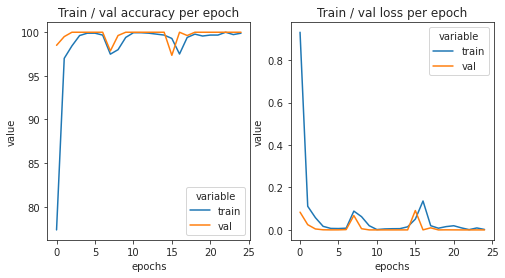

In [19]:
# metrics curves (loss and acc)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.lineplot(data=train_val_acc, x="epochs", y="value", hue="variable", ax=axes[0]).set_title("Train / val accuracy per epoch")
sns.lineplot(data=train_val_loss, x="epochs", y="value", hue="variable", ax=axes[1]).set_title("Train / val loss per epoch")

In [20]:
# average accuracy for test data not seen by model
accu = []
yhat_ls = []
labels_ls = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        yhat_ls.append(torch.max(outputs, dim=1)[1].cpu().numpy())
        labels_ls.append(labels.cpu().numpy())
        acc = accuracy(outputs, labels).item()
        accu.append(acc)
    print(f"avg acc for test data (not seen by model): {np.mean(accu)} %")

avg acc for test data(not seen by model): 82.75 %


In [21]:
# flatten yhats and labels
yhat_ls = [i for arr in yhat_ls for i in arr]
labels_ls = [i for arr in labels_ls for i in arr]

In [22]:
print(classification_report(labels_ls, yhat_ls))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       124
           1       0.89      0.87      0.88       124
           2       0.86      0.73      0.79       124

    accuracy                           0.82       372
   macro avg       0.83      0.82      0.82       372
weighted avg       0.83      0.82      0.82       372



In [23]:
confusion_matrix(labels_ls, yhat_ls)
idx2cls = {v:k for k, v in dataset.class_to_idx.items()}
conf_mx = pd.DataFrame(confusion_matrix(labels_ls, yhat_ls)).rename(columns=idx2cls, index=idx2cls)

<AxesSubplot:>

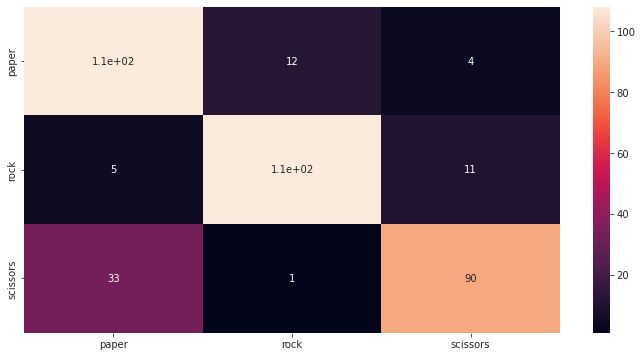

In [24]:
_, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(conf_mx, annot=True, ax=ax)